# Data Mining Project
### Giorgio Donati, g.donati24@studenti.unipi.it
### Pietro Francaviglia, p.francaviglia1@studenti.unipi.it
#### A.Y. 2021-2022


# Libraries and datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from col_names import *
from utility import *

In [2]:
with open(f'{PICKLE_FOLDER}basket_prepared_df.pkl', 'rb') as f:
    b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}item_prepared_df.pkl', 'rb') as f:
    i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}user_prepared_df.pkl', 'rb') as f:
    u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}shop_prepared_df.pkl', 'rb') as f:
    s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}date_prepared_df.pkl', 'rb') as f:
    d_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}total_prepared_df.pkl', 'rb') as f:
    total_df = pickle.load(f)

In [3]:
with open(f'{PICKLE_FOLDER}pure_basket_prepared_df.pkl', 'rb') as f:
    pure_b_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_item_prepared_df.pkl', 'rb') as f:
    pure_i_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_user_prepared_df.pkl', 'rb') as f:
    pure_u_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_shop_prepared_df.pkl', 'rb') as f:
    pure_s_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_date_prepared_df.pkl', 'rb') as f:
    pure_d_df = pickle.load(f)
with open(f'{PICKLE_FOLDER}pure_prepared_df.pkl', 'rb') as f:
    pure_df = pickle.load(f)

## Shop rankings and feature selection

In [4]:
def ranking_and_elimination(user_df, shop_df, corr_threshold=0.85, figsize=(25,12)):
    # new shop rankings
    shop_df[NAPR] = rankings(shop_df[PAVG], 0).astype('int64')
    shop_df[NABR] = rankings(shop_df[BCNT], 0).astype('int64')
    shop_df[NAIR] = rankings(shop_df[ICNT], 0).astype('int64')
    shop_df[FAPR] = rankings(shop_df[PAVG], 1).astype('int64')
    shop_df[FABR] = rankings(shop_df[BCNT], 1).astype('int64')
    shop_df[FAIR] = rankings(shop_df[ICNT], 1).astype('int64')

    # new user rankings
    user_df[[NABR, NAIR, NAPR]] = total_df.merge(shop_df[[NABR, NAIR, NAPR]], on=SHOP, how='left').groupby(USER)[[NABR, NAIR, NAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[NABR, NAIR, NAPR]], figsize=figsize)
    plt.show()

    user_df[[FABR, FAIR, FAPR]] = total_df.merge(shop_df[[FABR, FAIR, FAPR]], on=SHOP, how='left').groupby(USER)[[FABR, FAIR, FAPR]].mean()
    pd.plotting.scatter_matrix(user_df[[FABR, FAIR, FAPR]], figsize=figsize)
    plt.show()
    # scatter matrix with all variables
    # pd.plotting.scatter_matrix(user_df, figsize=corr_figsize)

    # pairwise correlation matrix among new variables
    _, axes = plt.subplots(1, 1, figsize=figsize)
    corr_new_matrix = user_df.set_index(USER)[[NABR, NAIR, NAPR, FABR, FAIR, FAPR]].corr()
    sns.heatmap(corr_new_matrix, annot=True, cmap="YlGnBu", ax=axes)
    plt.xticks(rotation=60)
    plt.show()

    # elimination of redundant features
    corr_matrix = user_df.set_index(USER).corr()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] >= corr_threshold)]
    print(f"Removed features: {to_drop}")
    func_df = user_df.drop(user_df[to_drop], axis=1)
    func_df = func_df.drop(USER, axis=1)
    return func_df

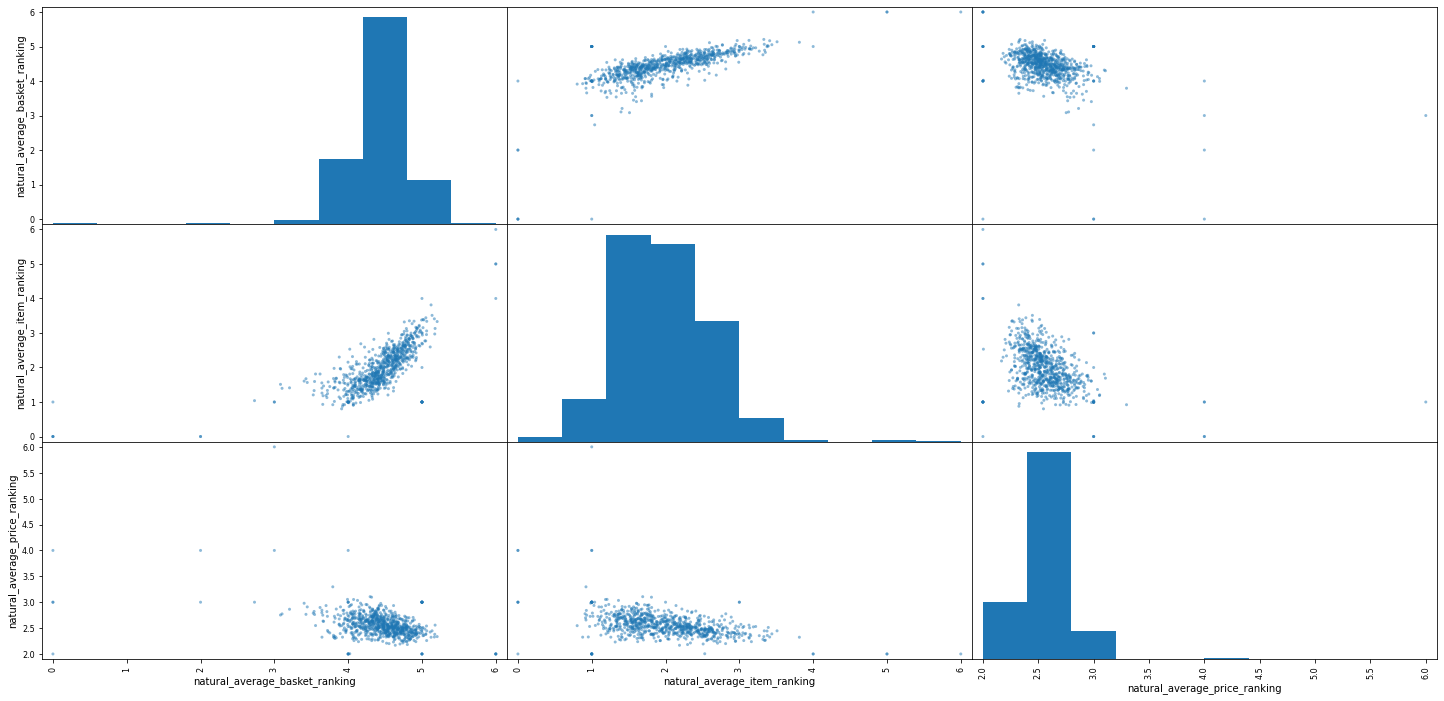

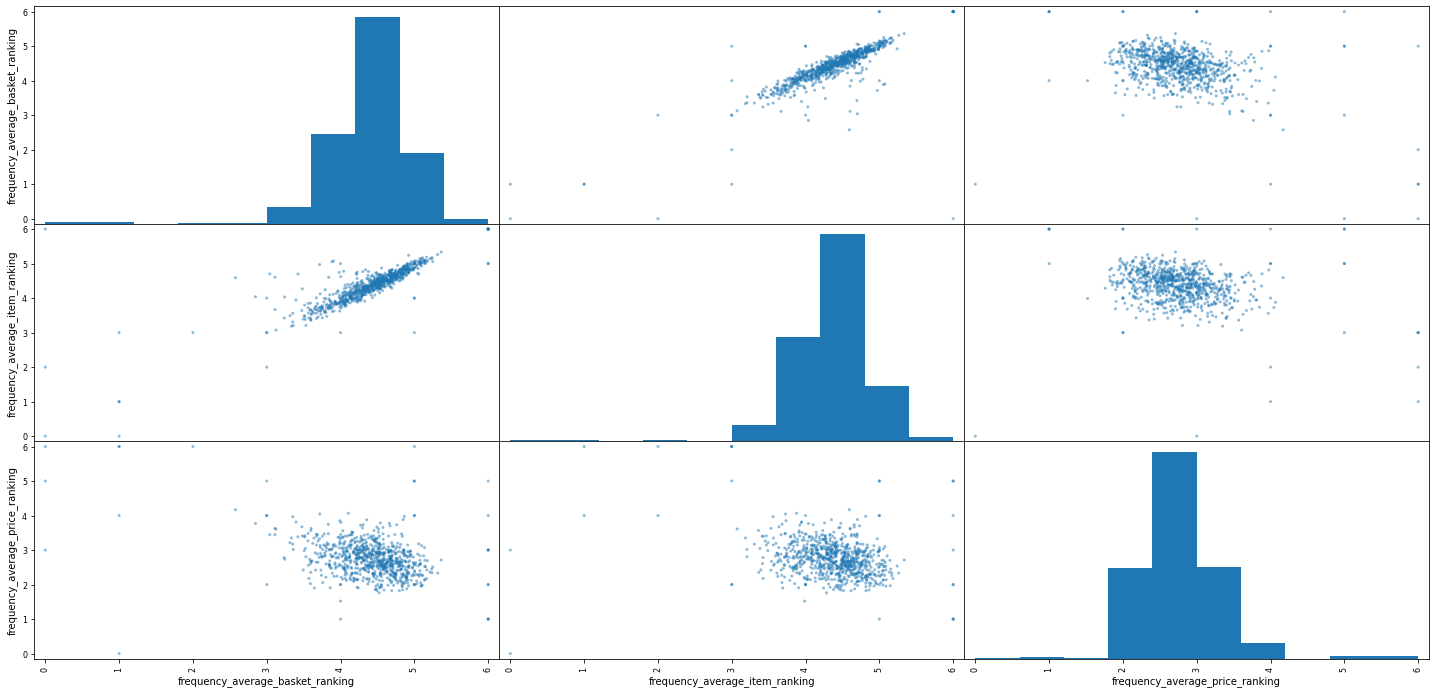

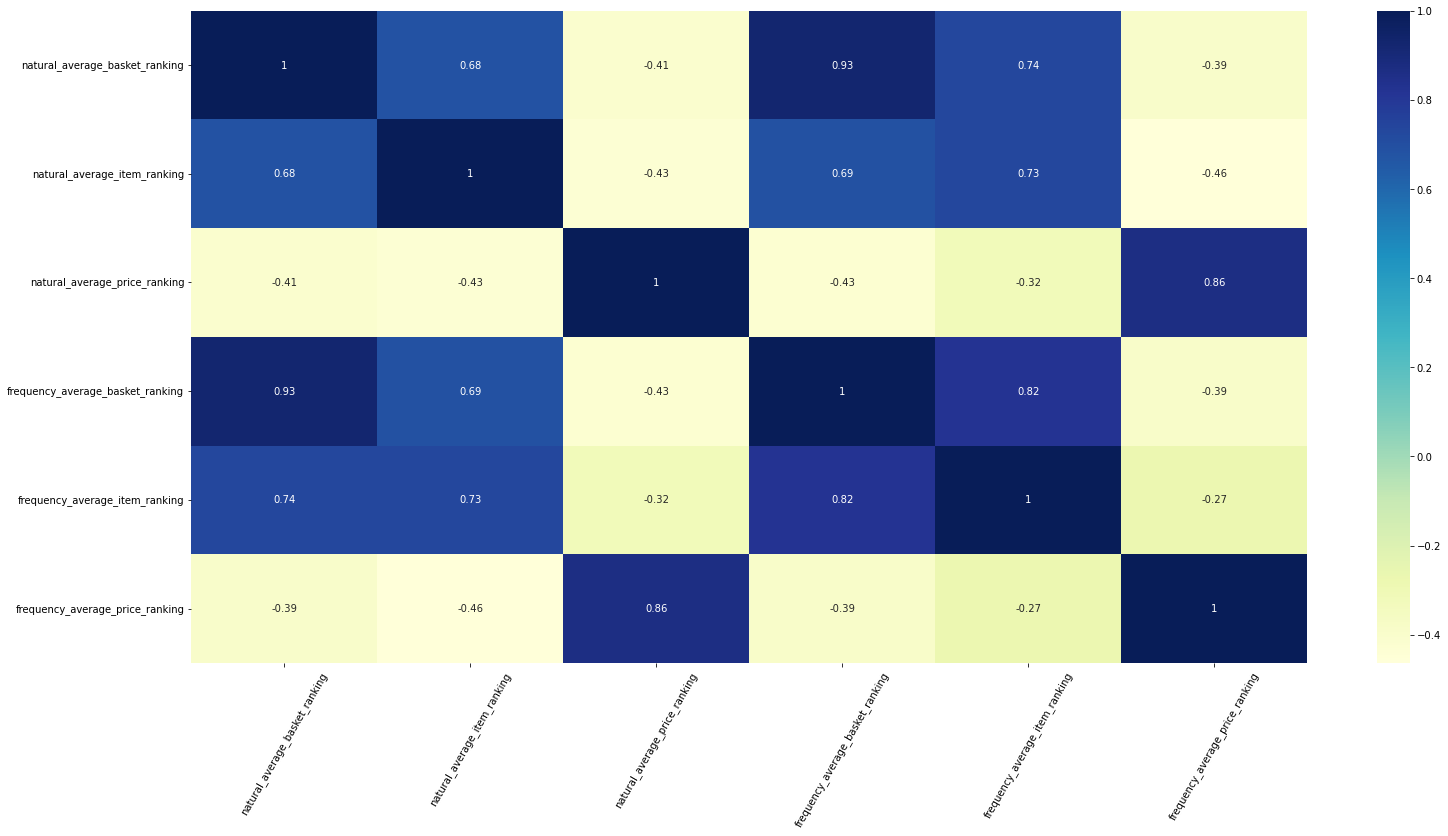

Removed features: ['item_dist_count', 'item_entropy', 'total_price', 'basket_count', 'shop_count', 'frequency_average_basket_ranking', 'frequency_average_price_ranking']


In [5]:
clustering_df = ranking_and_elimination(u_df, s_df)

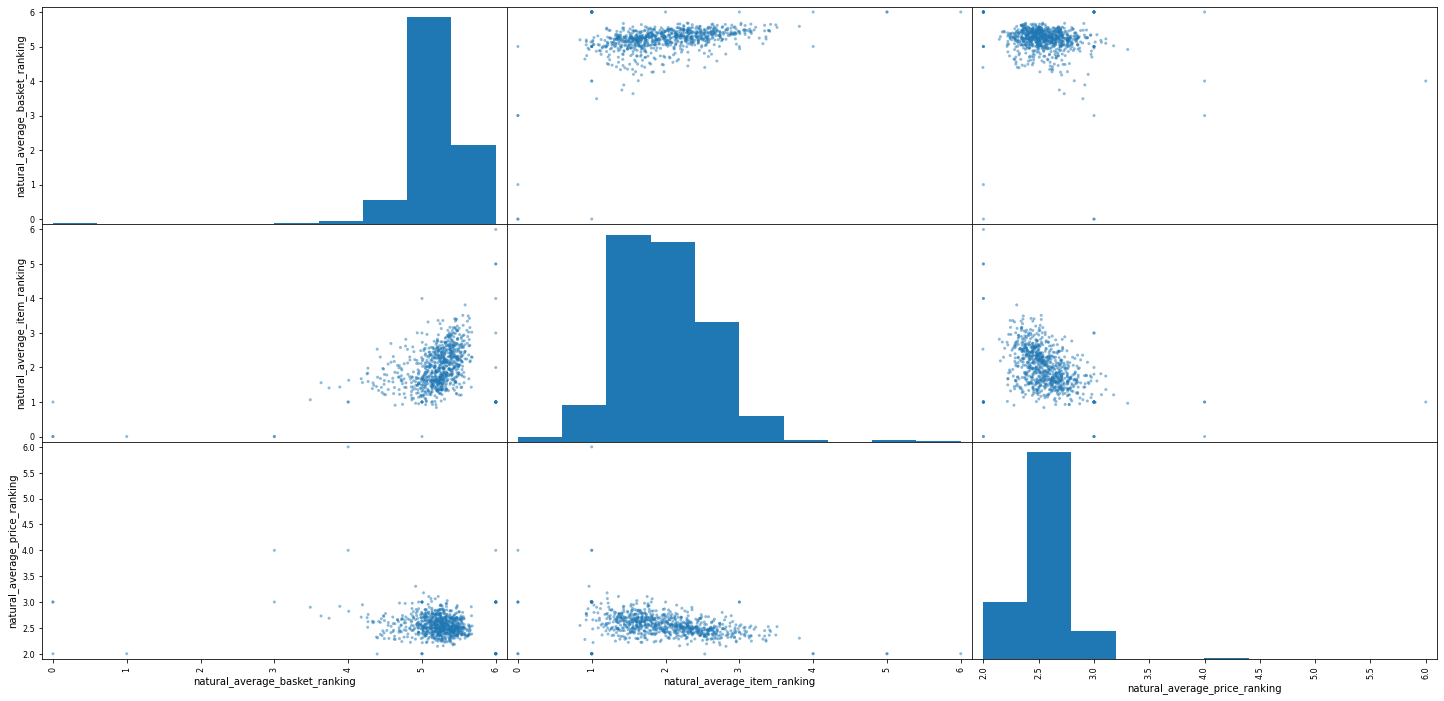

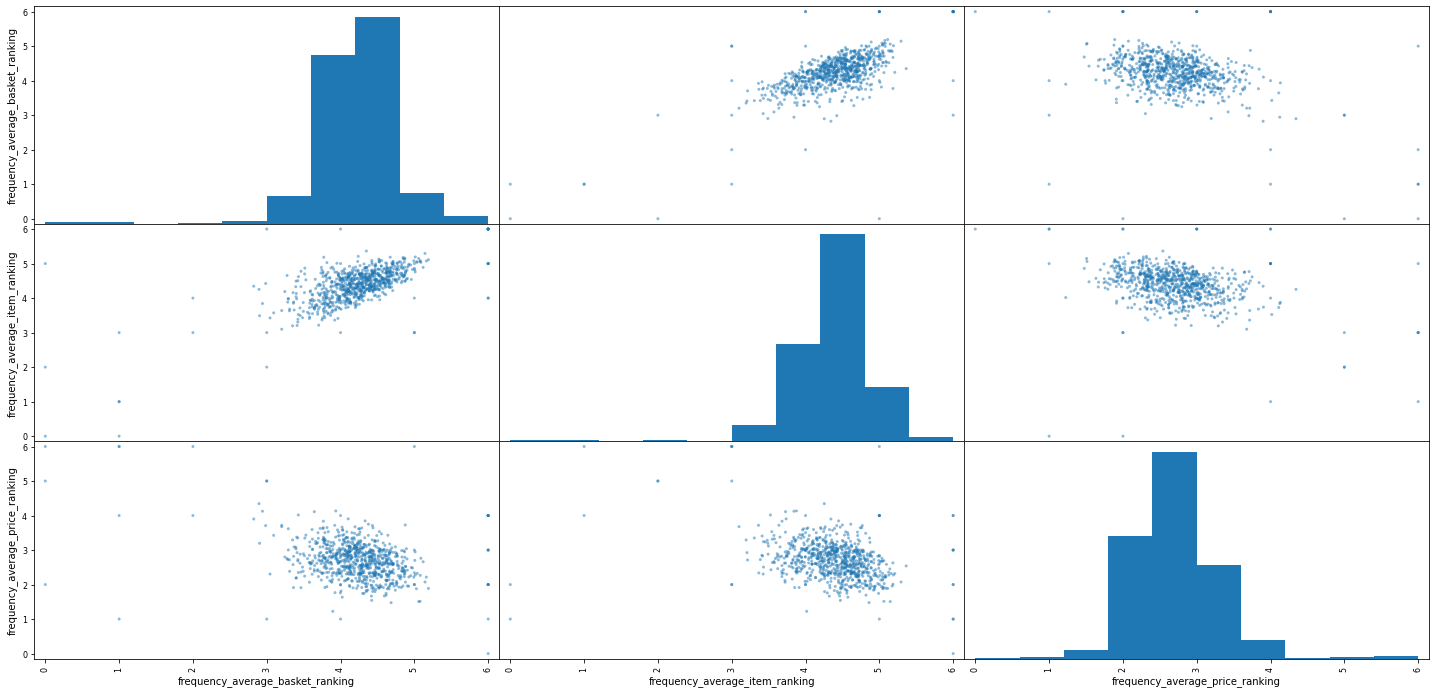

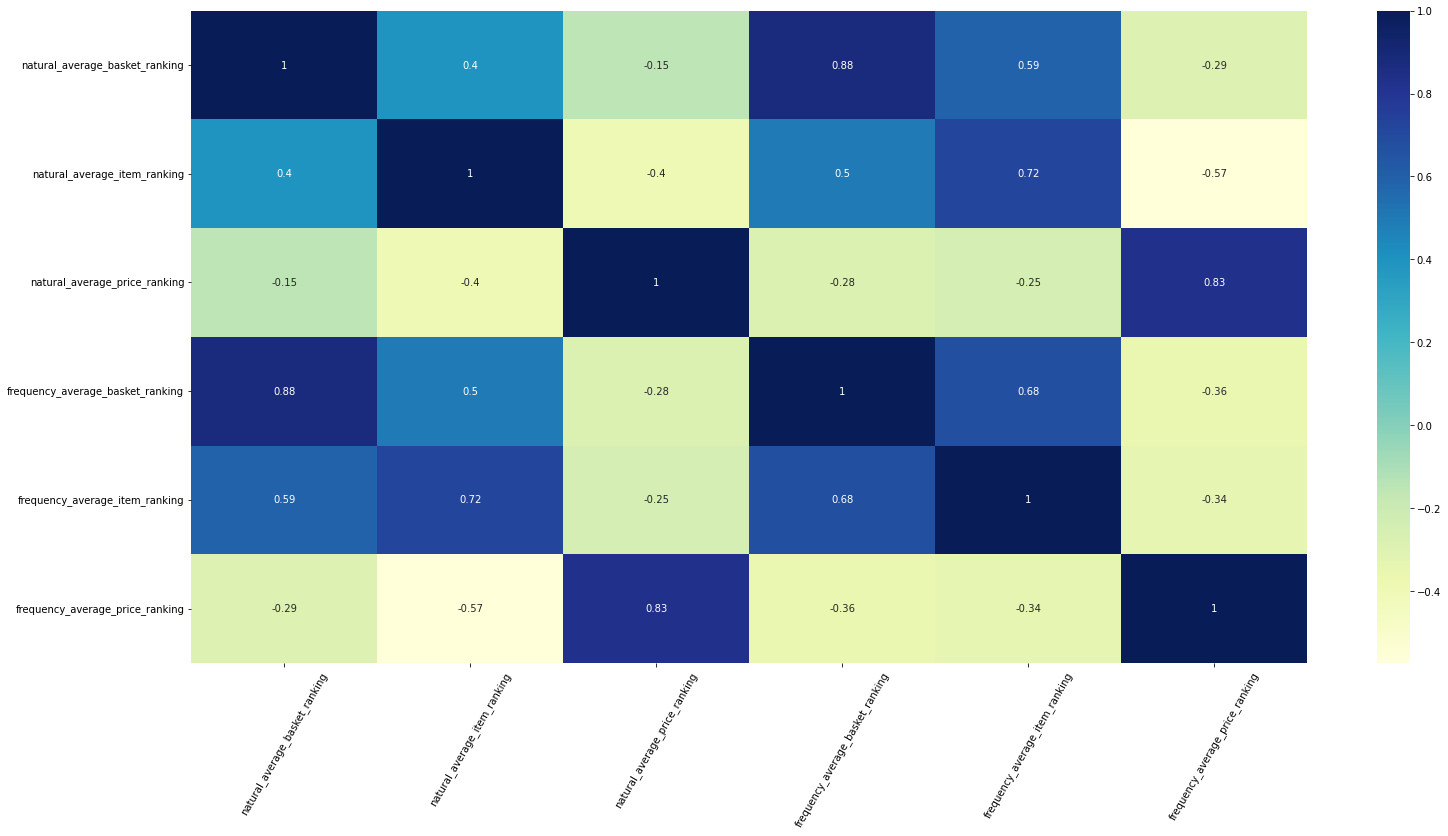

Removed features: ['item_dist_count', 'item_entropy', 'total_price', 'basket_count', 'shop_count', 'frequency_average_basket_ranking']


In [6]:
pure_clustering_df = ranking_and_elimination(pure_u_df, pure_s_df)

In [7]:
with open(f'{PICKLE_FOLDER}clustering_df.pkl', 'wb') as f:
    pickle.dump(clustering_df, f)

with open(f'{PICKLE_FOLDER}pure_clustering_df.pkl', 'wb') as f:
    pickle.dump(pure_clustering_df, f)